# test what happens when i flip the voxel data to RAS and then save the nifti

In [ ]:
import nibabel as nib
print(nib.__version__)
import SimpleITK as stik



nifti_path = "/home/ayeluru/vascular-superenhancement-4d-flow/working_dir/all_patients/patient_data/Amupam/nifti/3d_cine_Amupam.nii.gz"


In [26]:

# load the nifti file using nibabel
nifti_file_nib = nib.load(nifti_path)
# get the voxel data from nibabel
nifti_nib = nifti_file_nib.get_fdata()
print(nifti_nib.shape)
# flip the voxel data axes to RAS
# nifti_nib = nifti_nib[::-1, ::-1, :]
print(nifti_nib.shape)

(512, 512, 96, 20)
(512, 512, 96, 20)


In [28]:
# load the nifti file using simpleitk
nifti_file_sit = stik.ReadImage(nifti_path)
# get the voxel data from simpleitk
nifti_sit = stik.GetArrayFromImage(nifti_file_sit)
print(nifti_sit.shape)

# transpose the voxel data axes to RAS
# nifti_sit = np.transpose(nifti_sit, (3, 2, 1, 0))
print(nifti_sit.shape)


(20, 96, 512, 512)
(20, 96, 512, 512)


## visualize

In [ ]:
# plot the first 30 z slices of nifti_nib and nifti_sit as a series of plots with 2 subplots

import matplotlib.pyplot as plt

# Create figure with 2 rows and 15 columns


# Plot first 15 slices from nibabel data
for i in range(50):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(nifti_nib[:,:,i,0], cmap='gray')
    axes[0].axis('off')
    axes[0].set_title(f'Slice {i} (nibabel)')
    
    axes[1].imshow(nifti_sit[0,i,:,:], cmap='gray') 
    axes[1].axis('off')
    axes[1].set_title(f'Slice {i} (SimpleITK)')

plt.tight_layout()





## test a fix

In [32]:

# --- Input and output paths ---
fixed_path = "/home/ayeluru/vascular-superenhancement-4d-flow/working_dir/all_patients/patient_data/Bukrukesh/nifti/3d_cine_Bukrukesh_fixed.nii.gz"

# --- Load NIfTI ---
img = nib.load(nifti_path)
data = img.get_fdata()
affine = img.affine  # already RAS

# --- Flip voxel data from LPS → RAS (X: L→R, Y: P→A) ---
# data_flipped = data[::-1, ::-1, ...]  # works for 3D or 4D

# --- Save corrected NIfTI ---
fixed_img = nib.Nifti1Image(data_flipped, affine)
fixed_img.set_qform(affine, code=1)
fixed_img.set_sform(affine, code=1)

hdr = fixed_img.header
hdr['dim'][0] = 4
hdr['dim'][4] = data_flipped.shape[3]
hdr['pixdim'][4] = 1.0  # or actual time spacing in seconds
hdr['xyzt_units'] = 2 | 8  # space in mm, time in seconds

nib.save(fixed_img, fixed_path)
print(f"✅ Saved corrected NIfTI to:\n{fixed_path}")

✅ Saved corrected NIfTI to:
/home/ayeluru/vascular-superenhancement-4d-flow/working_dir/all_patients/patient_data/Amupam/nifti/3d_cine_Amupam_fixed.nii.gz


# testing from scratch

In [84]:
import pandas as pd

sub_catalog_path = "/home/ayeluru/vascular-superenhancement-4d-flow/working_dir/all_patients/patient_data/Bukrukesh/dicom_catalog_3d-cine_Bukrukesh.csv"
sub_catalog = pd.read_csv(sub_catalog_path)

In [85]:
sub_catalog = sub_catalog.copy()
sub_catalog['ipp'] = sub_catalog['imagepositionpatient'].apply(lambda x: np.array(eval(x)))
sub_catalog['z'] = sub_catalog['ipp'].apply(lambda x: x[2])
sub_catalog['pixelspacing'] = sub_catalog['pixelspacing'].apply(lambda x: np.array(eval(x)))
sub_catalog['imageorientation'] = sub_catalog['imageorientation'].apply(lambda x: np.array(eval(x)))

In [86]:
 # === Process each timepoint ===
time_indices = sorted(sub_catalog['time_index'].unique())
volume_list = []

In [ ]:
import SimpleITK as sitk
import pydicom

for t in time_indices:
    sub_catalog_t = sub_catalog[sub_catalog['time_index'] == t].copy()
    sub_catalog_t = sub_catalog_t.sort_values('z', ascending=True)  # Inferior → Superior
    filepaths = sub_catalog_t['filepath'].tolist()
    
    for filepath in filepaths:
        dcm = pydicom.dcmread(filepath)
        img = dcm.pixel_array
        
    
    reader = sitk.ImageSeriesReader()
    reader.SetFileNames(filepaths)
    image3d = reader.Execute()
    
    vol = sitk.GetArrayFromImage(image3d)  # shape: [Z, Y, X]
    print(vol.shape)
    volume_list.append(vol)

(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)
(119, 256, 256)


In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(vol[i,:,:], cmap='gray')
    plt.show()


In [71]:
import numpy as np
 # === Stack into 4D array ===


arr4d = np.stack(volume_list, axis=-1)  # shape: [Z, Y, X, T]
arr4d = np.transpose(arr4d, (2, 1, 0, 3))  # → [X, Y, Z, T]

In [72]:
import pydicom
from typing import Dict, Union, Optional

# === Compute affine ===
sub_catalog_0 = sub_catalog[sub_catalog['time_index'] == 0].copy()
sub_catalog_0 = sub_catalog_0.sort_values('z', ascending=True).reset_index(drop=True)

dcm0 = pydicom.dcmread(sub_catalog_0.iloc[0]['filepath'])
dcm1 = pydicom.dcmread(sub_catalog_0.iloc[1]['filepath'])
print(sub_catalog_0.iloc[0]['filepath'])
print(sub_catalog_0.iloc[1]['filepath'])

def _compute_affine(
        ds0: pydicom.Dataset,
        ds1: Optional[pydicom.Dataset] = None,
    ) -> tuple[np.ndarray, float]:
        """
        Return a 4 × 4 voxel‑to‑patient affine and the dot product for slice direction check.

        Priority for slice spacing Δs:
        1.  SpacingBetweenSlices (centre‑to‑centre) if > 0
        2.  Distance between the first two ImagePositionPatient vectors
        3.  SliceThickness
        4.  Fallback = 1 mm

        Also logs if slice order appears flipped w.r.t. orientation.
        """
        # ------------------------------------------------------------- #
        # 1.  Extract row/col direction vectors and in‑plane spacing
        # ------------------------------------------------------------- #
        try:
            row = np.asarray(ds0.ImageOrientationPatient[:3], dtype=float)
            col = np.asarray(ds0.ImageOrientationPatient[3:], dtype=float)
            Δr, Δc = map(float, ds0.PixelSpacing)
            origin = np.asarray(ds0.ImagePositionPatient, dtype=float)
            print(origin)
        except AttributeError as err:
            print(
                f"[{self.patient_id}] Missing mandatory orientation/spacing tags "
                f"({err}); using identity affine."
            )
            return np.eye(4), 0.0

        # ------------------------------------------------------------- #
        # 2.  Determine slice spacing Δs
        # ------------------------------------------------------------- #
        Δs: float
        ipp1 = None
        if ds1 is not None:
            ipp1 = np.asarray(ds1.ImagePositionPatient, dtype=float)
            Δs = np.linalg.norm(ipp1 - origin)
            print(f"Computed Δs from ΔIPP = {Δs:.3f} mm")
        elif hasattr(ds0, "SpacingBetweenSlices") and float(ds0.SpacingBetweenSlices) > 0:
            Δs = float(ds0.SpacingBetweenSlices)
            print(f"Using SpacingBetweenSlices={Δs:.3f} mm")
        elif hasattr(ds0, "SliceThickness"):
            Δs = float(ds0.SliceThickness)
            print(f"Using SliceThickness={Δs:.3f} mm")
        else:
            Δs = 1.0
            print(
                f"[{self.patient_id}] No slice‑spacing tag present; defaulting to 1 mm."
            )

        # ------------------------------------------------------------- #
        # 3.  Build LPS affine columns
        # ------------------------------------------------------------- #
        # Compute slice normal using right-handed coordinate system
        # DICOM standard specifies row × col for the slice normal
        slice_vec = np.cross(row, col)
        
        # Log all components used to build the affine
        print(
            f"  Affine components:\n"
            f"  Row vector: {row}\n"
            f"  Col vector: {col}\n"
            f"  Slice normal (row × col): {slice_vec}\n"
            f"  Pixel spacing: (Δr={Δr:.3f}, Δc={Δc:.3f})\n"
            f"  Slice spacing: Δs={Δs:.3f}\n"
            f"  Origin: {origin}"
        )

        affine = np.eye(4)
        affine[:3, 0] = row * Δr
        affine[:3, 1] = col * Δc
        affine[:3, 2] = slice_vec * Δs
        affine[:3, 3] = origin

        print(f"Initial LPS affine matrix:\n{affine}")
        
        # ------------------------------------------------------------- #
        # 4.  Build RAS affine columns
        # ------------------------------------------------------------- #
        # flip = np.eye(4)
        # flip[0, 0] = -1  # L → R
        # flip[1, 1] = -1  # P → A
        # affine_ras = flip @ affine
        
        # self.logger.debug(f"[{self.patient_id}] Final RAS affine matrix:\n{affine_ras}")
        
        return affine

affine = _compute_affine(dcm0, dcm1)

/home/ayeluru/mnt/fourier/repository/vascular-superenhancement-4d-flow/all_patients/unzipped_files/Bukrukesh/2.25.50698007932306277566771240219294900676/2.25.163030857173716970929908361316477815733/2.25.118073900951183327567863104482801968586.dcm
/home/ayeluru/mnt/fourier/repository/vascular-superenhancement-4d-flow/all_patients/unzipped_files/Bukrukesh/2.25.50698007932306277566771240219294900676/2.25.163030857173716970929908361316477815733/2.25.313030735356749006638646586594357005772.dcm
[-157.75376892 -167.9417572  -101.77381897]
Computed Δs from ΔIPP = 2.000 mm
  Affine components:
  Row vector: [ 0.98745 -0.10713  0.11601]
  Col vector: [0.10738 0.99421 0.00411]
  Slice normal (row × col): [-0.11577861  0.00839873  0.99323628]
  Pixel spacing: (Δr=1.484, Δc=1.484)
  Slice spacing: Δs=2.000
  Origin: [-157.75376892 -167.9417572  -101.77381897]
Initial LPS affine matrix:
[[ 1.46577078e+00  1.59394872e-01 -2.31557555e-01 -1.57753769e+02]
 [-1.59023772e-01  1.47580532e+00  1.67974934e-

In [73]:
print(arr4d.shape)

(256, 256, 119, 20)


In [ ]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(arr4d[:,:,i,0], cmap='gray')
    plt.show()

In [59]:
# Create NIfTI image
nii = nib.Nifti1Image(arr4d, affine)
nii.set_qform(affine, code=1)
nii.set_sform(affine, code=1)

hdr = nii.header
hdr['dim'][0] = 4
hdr['dim'][4] = arr4d.shape[3]
hdr['pixdim'][4] = 1.0  # or actual time spacing in seconds
hdr['xyzt_units'] = 2 | 8  # space in mm, time in seconds


nib.save(nii, fixed_path)
print(f"Saved 3D cine NIfTI to {fixed_path}")

Saved 3D cine NIfTI to /home/ayeluru/vascular-superenhancement-4d-flow/working_dir/all_patients/patient_data/Amupam/nifti/3d_cine_Amupam_fixed.nii.gz


In [62]:
nii = nib.load(fixed_path)
data = nii.get_fdata()
print(data.shape)


nii_sitk = sitk.ReadImage(fixed_path)
data_sitk = sitk.GetArrayFromImage(nii_sitk)
print(data_sitk.shape)


(512, 512, 96, 20)
(20, 96, 512, 512)


In [ ]:
import matplotlib.pyplot

for i in range(50):
    matplotlib.pyplot.imshow(data[:,:,i,0], cmap='gray')
    matplotlib.pyplot.show()

# some affine rounding shit???

In [80]:
bukrukesh_path = "/home/ayeluru/vascular-superenhancement-4d-flow/working_dir/all_patients/patient_data/Bukrukesh/nifti/3d_cine_Bukrukesh.nii.gz"

nifti = nib.load(bukrukesh_path)
data = nifti.get_fdata()

np.set_printoptions(precision=3, suppress=True)
print(data.shape)
print(nifti.affine)
print(nib.aff2world(nifti.affine))


flip = np.eye(4)
flip[0, 0] = -1  # L → R
flip[1, 1] = -1  # P → A
test_affine = flip @ nifti.affine

print(test_affine)
print(nib.aff2world(test_affine))





(256, 256, 119, 20)
[[  -1.466   -0.159    0.232  157.754]
 [   0.159   -1.476   -0.017  167.942]
 [   0.172    0.006    1.986 -101.774]
 [   0.       0.       0.       1.   ]]


AttributeError: module 'nibabel' has no attribute 'aff2world'

In [76]:
nib.aff2axcodes(nifti.affine)

('L', 'P', 'S')

(256, 256, 119, 20)


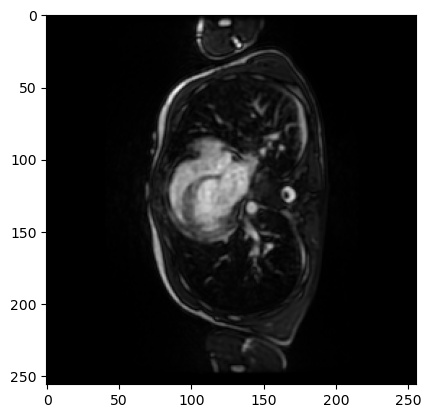

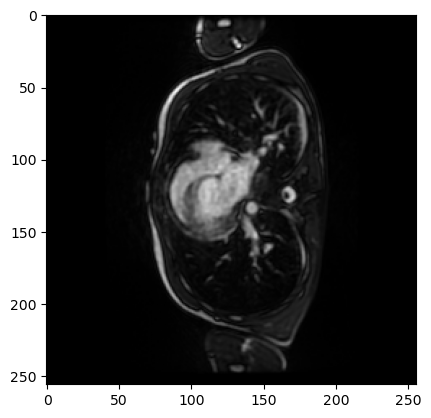

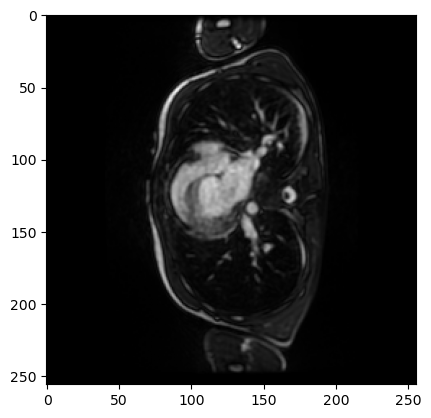

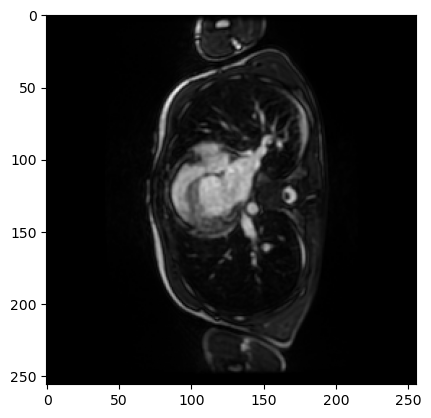

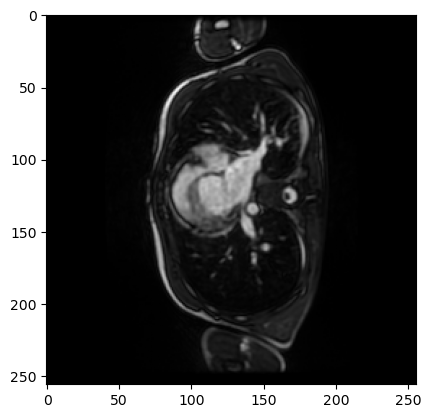

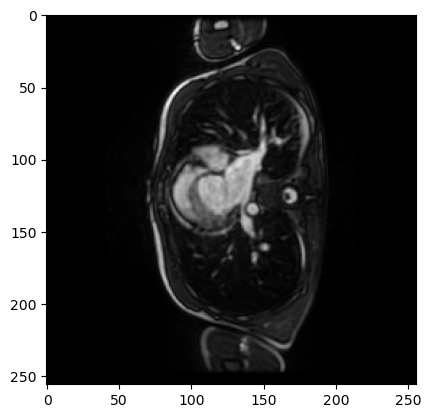

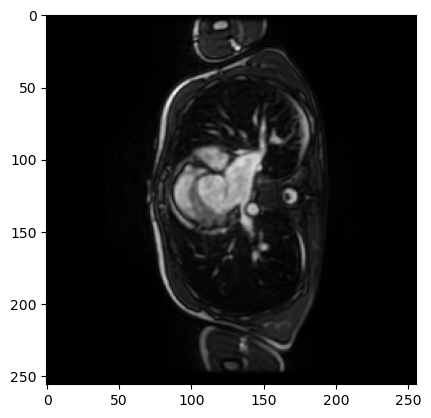

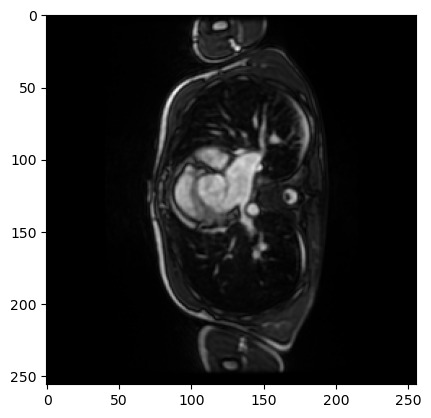

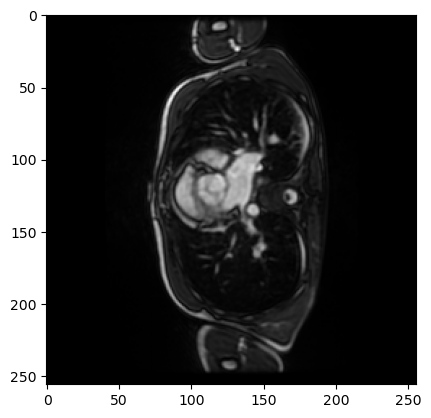

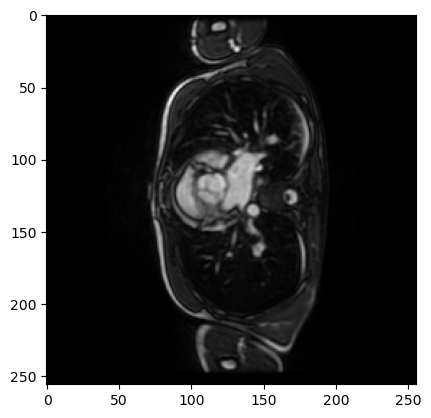

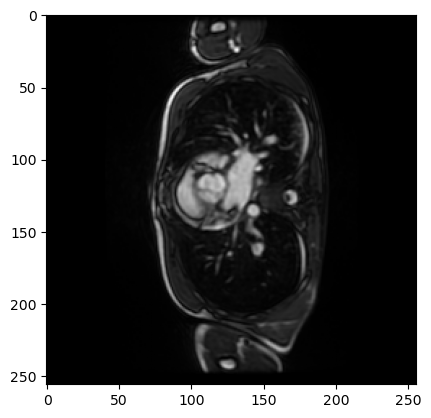

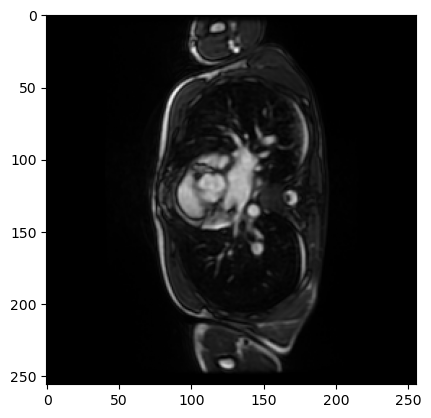

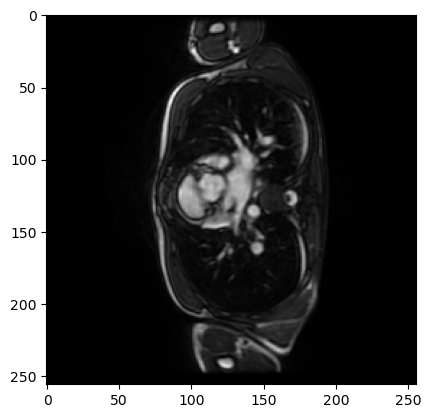

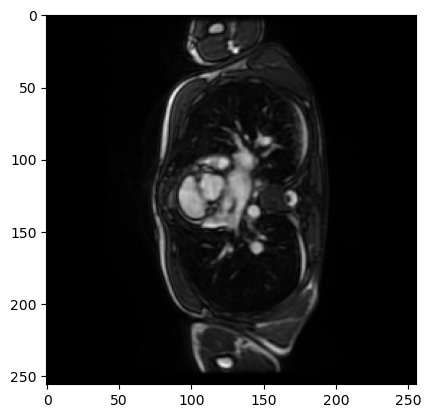

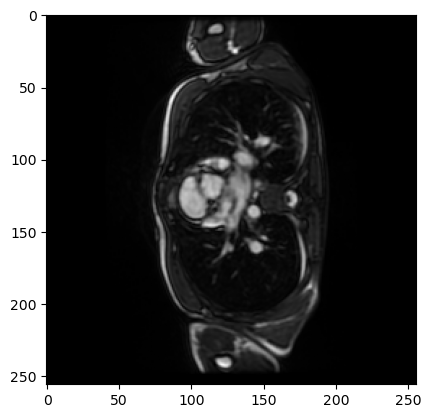

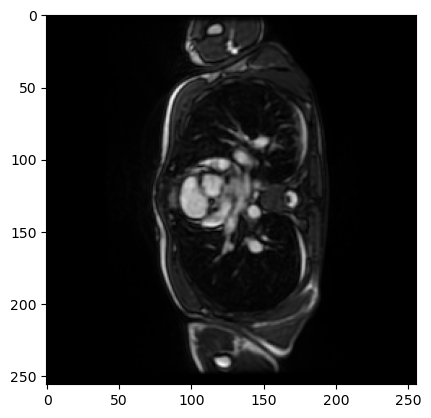

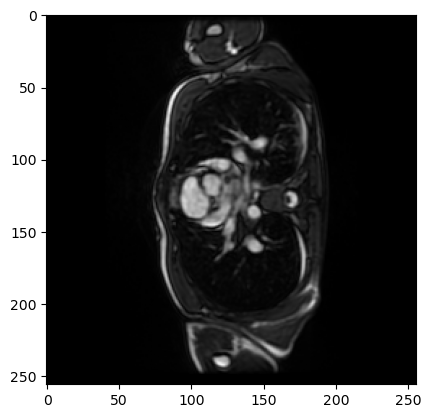

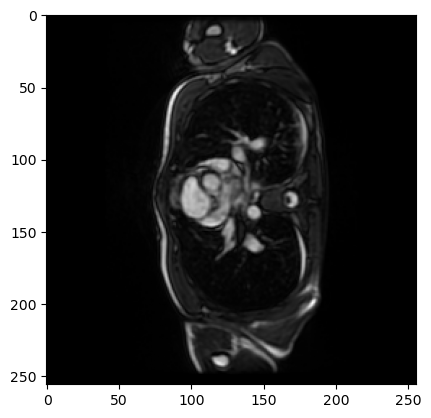

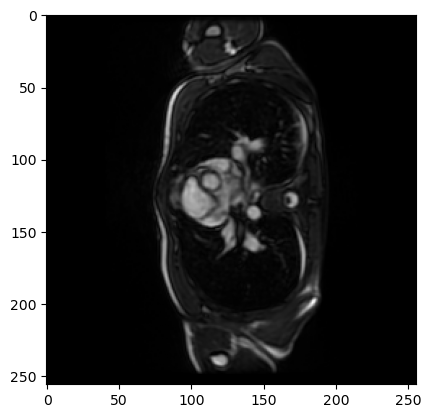

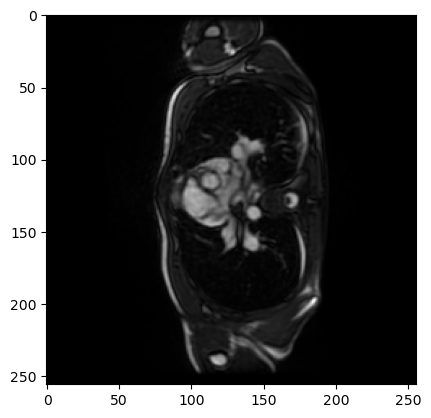

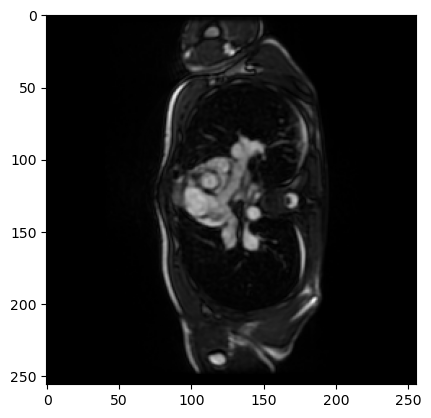

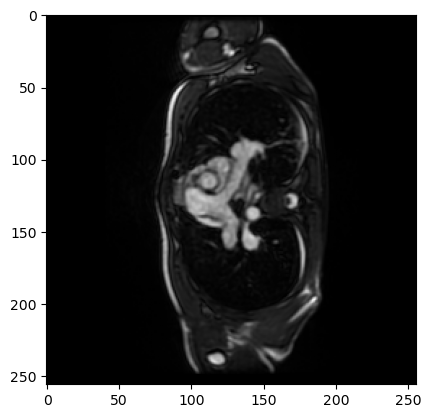

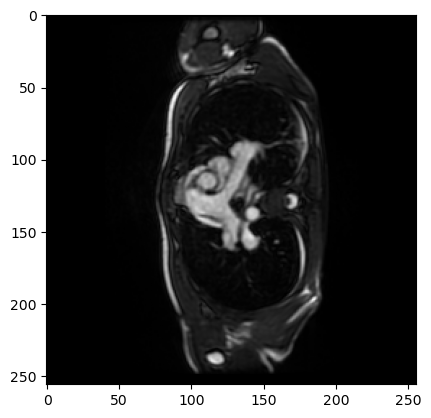

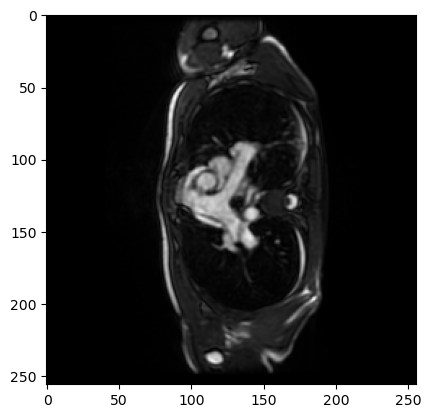

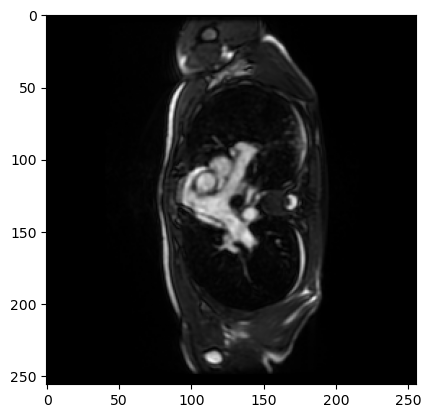

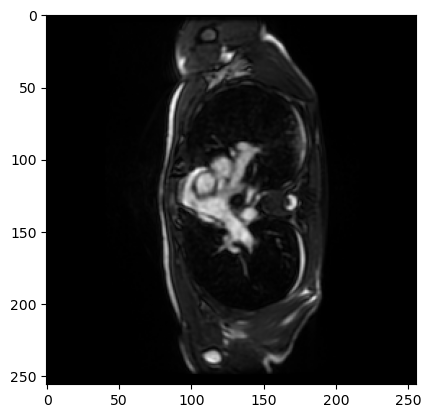

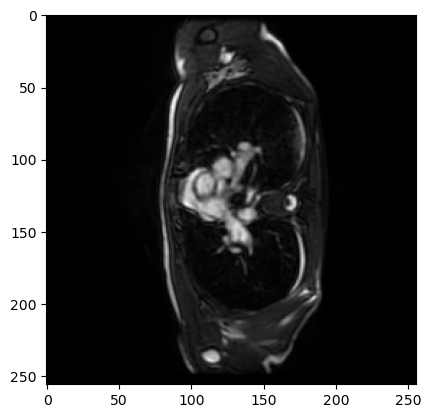

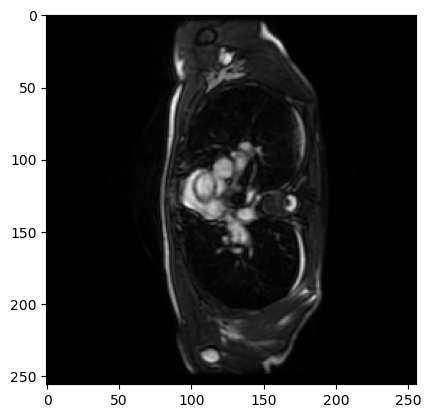

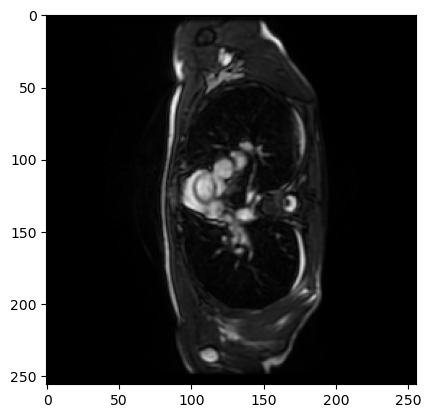

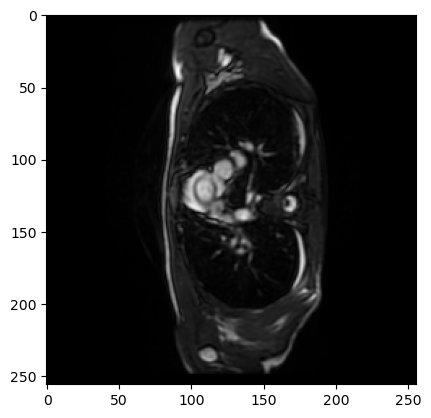

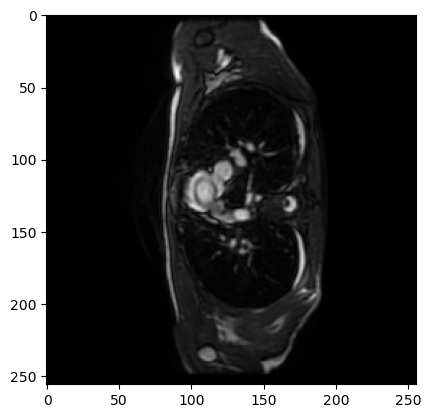

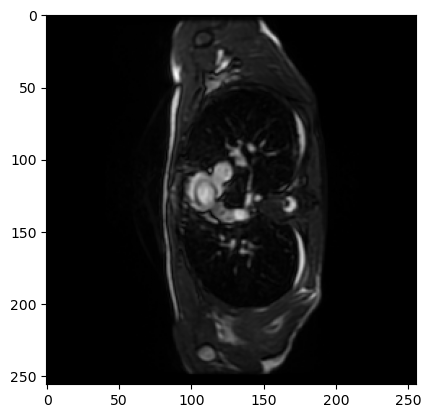

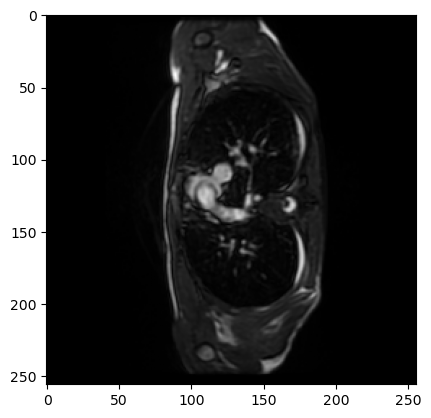

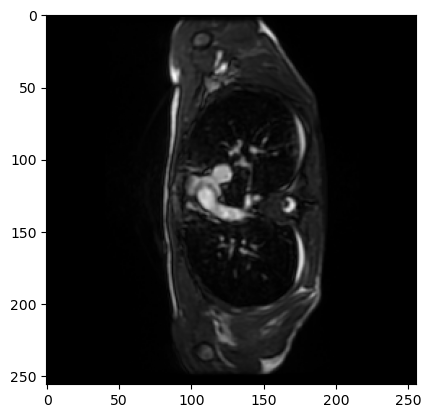

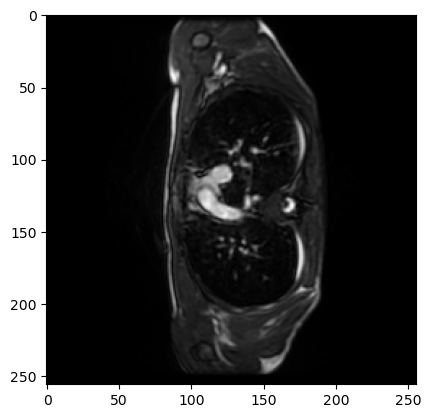

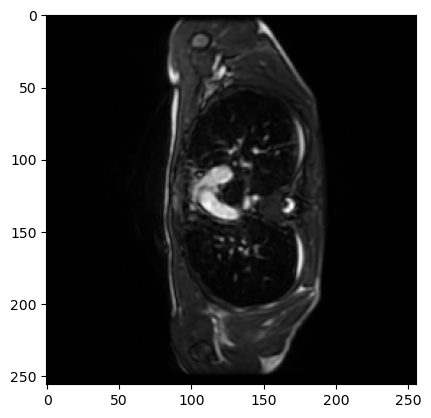

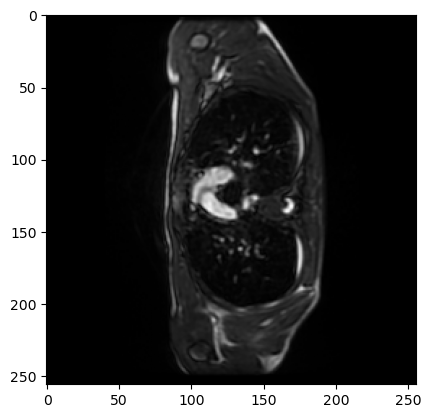

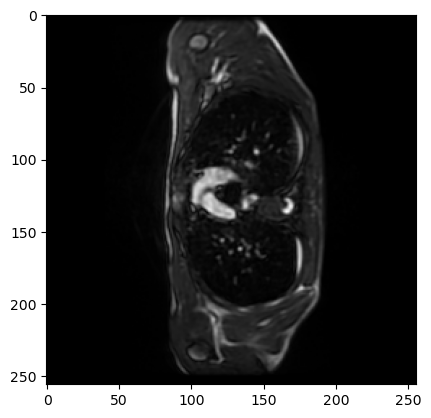

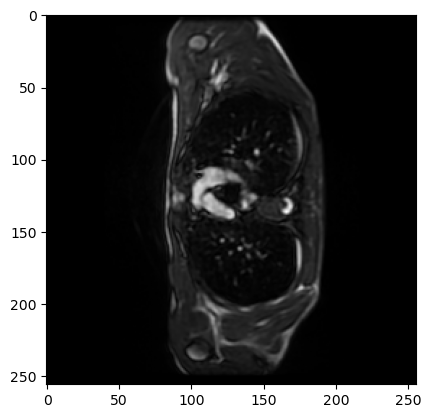

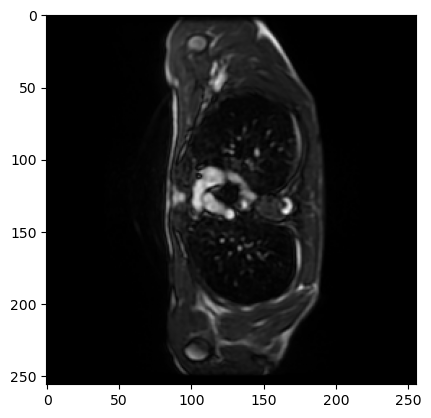

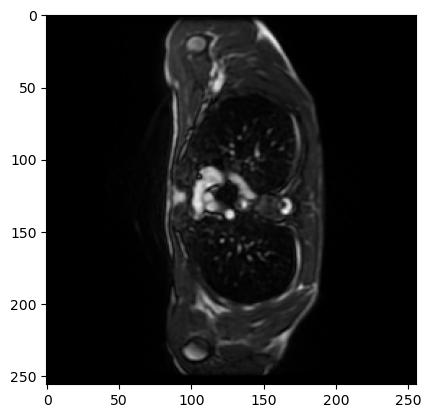

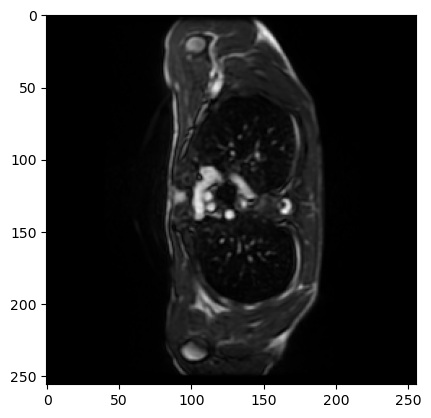

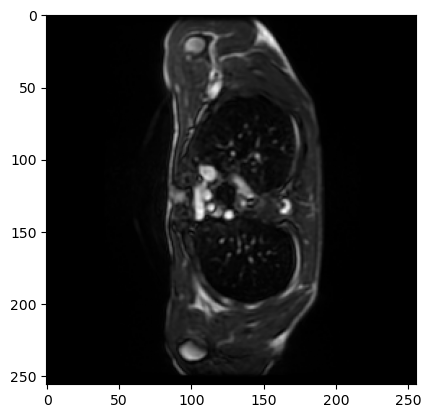

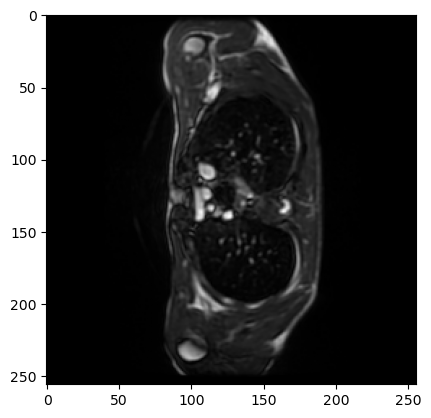

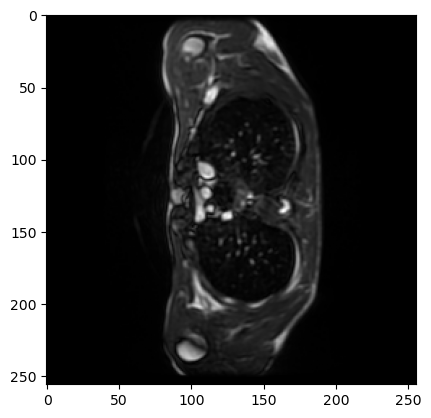

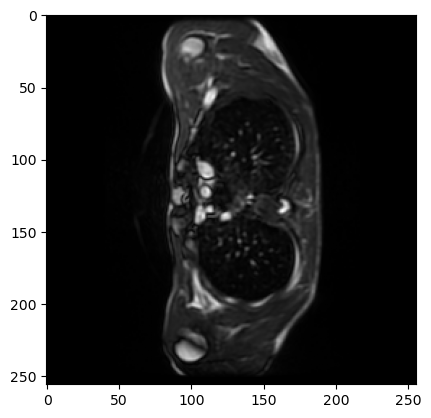

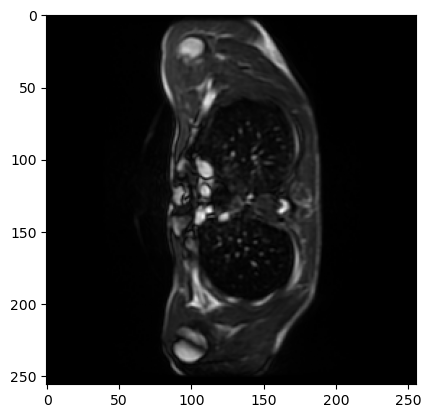

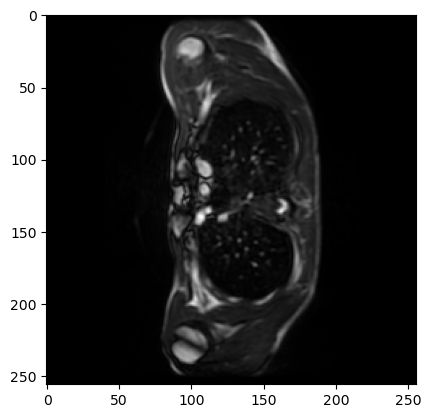

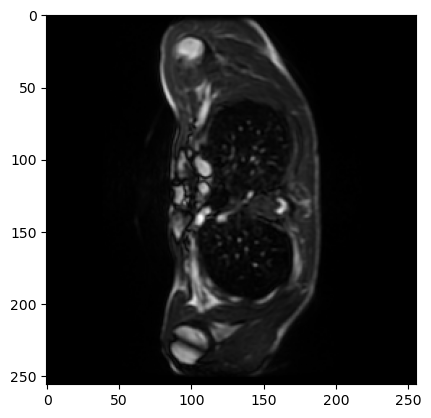

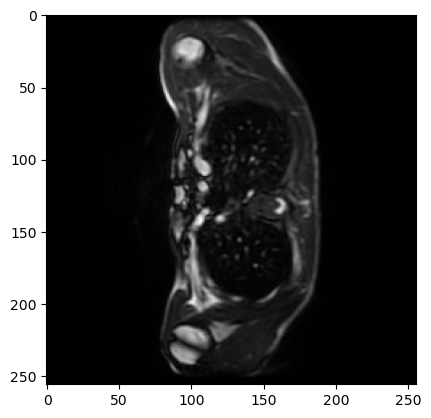

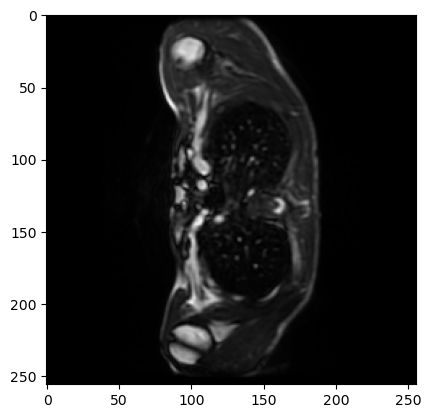

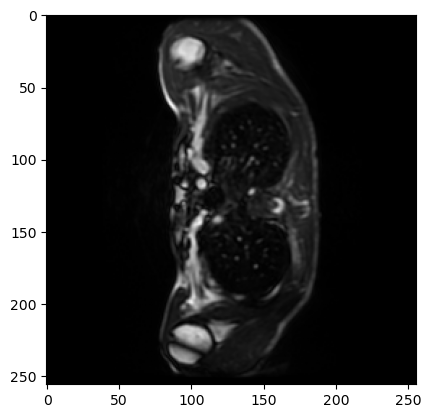

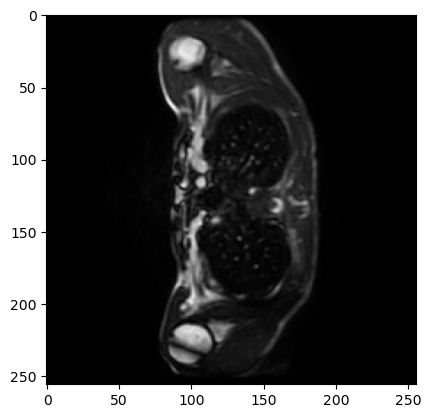

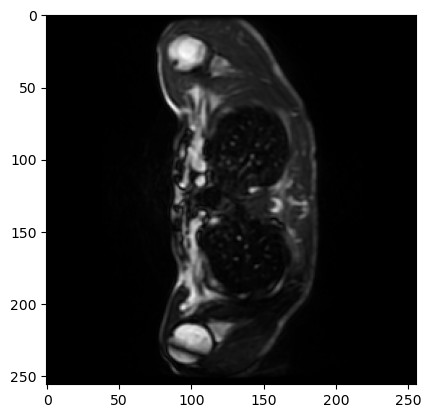

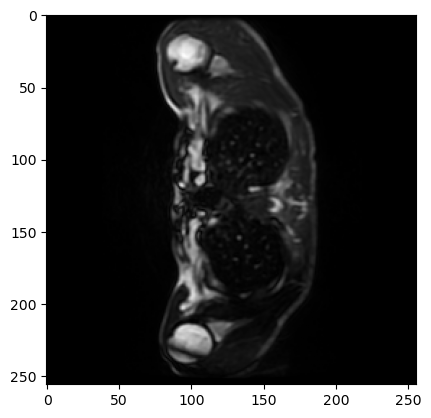

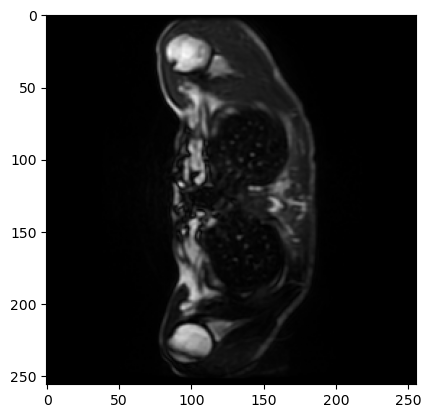

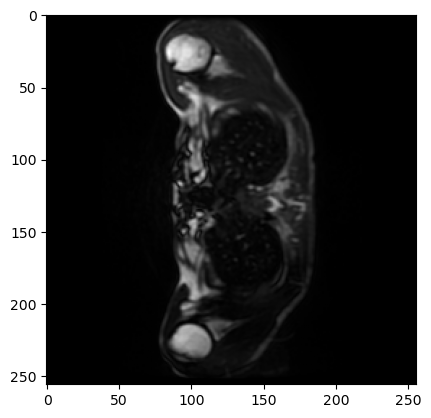

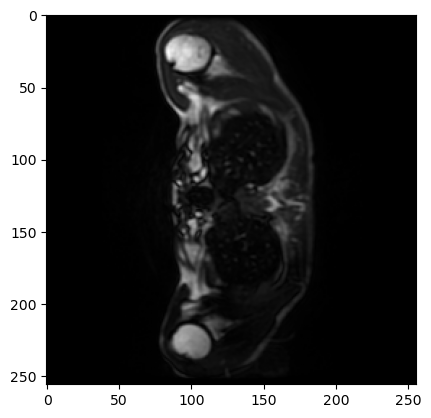

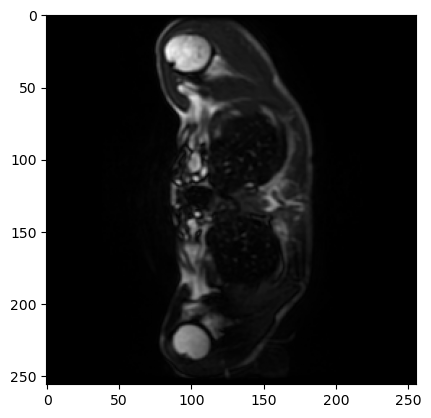

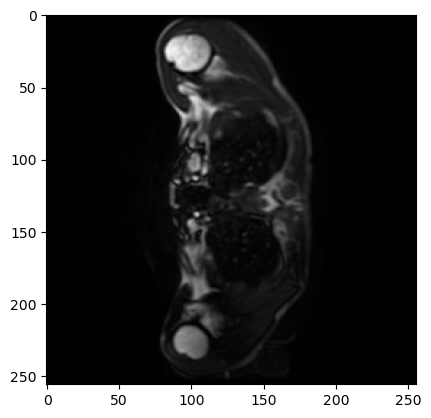

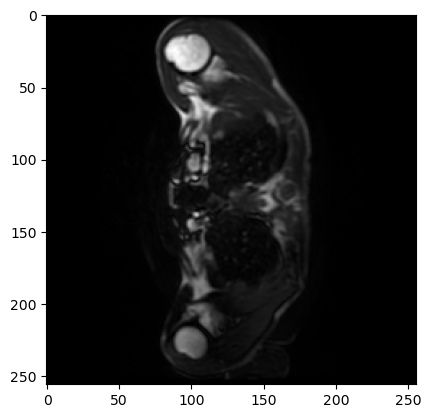

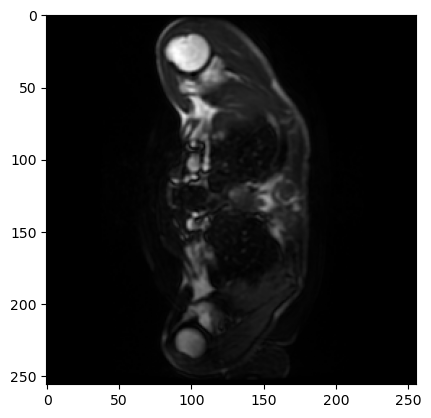

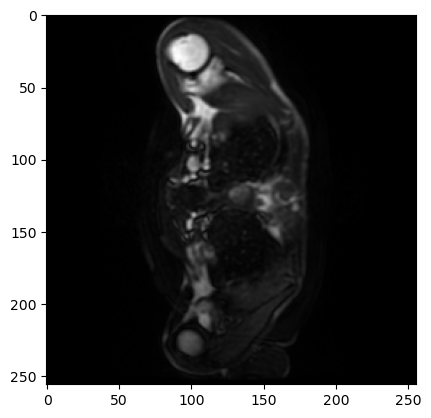

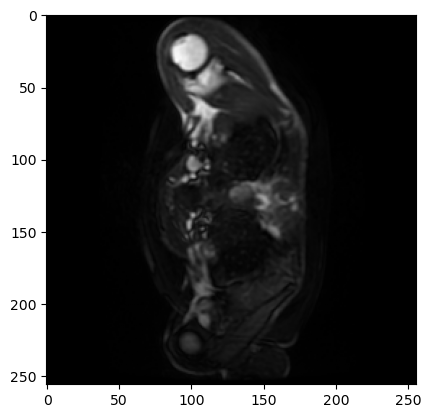

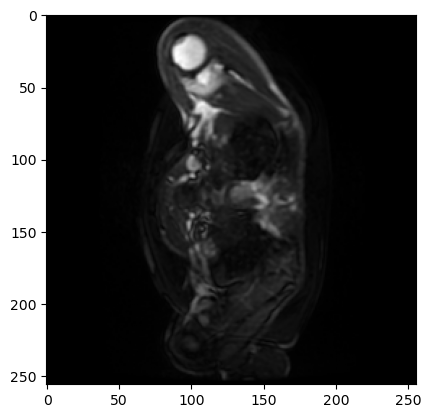

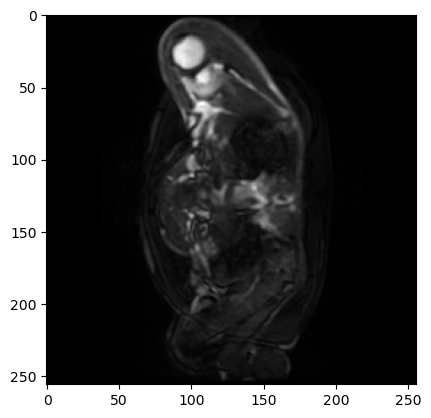

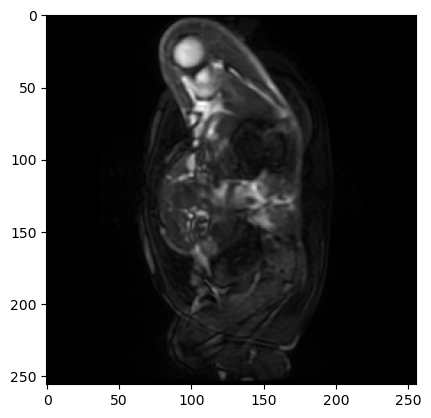

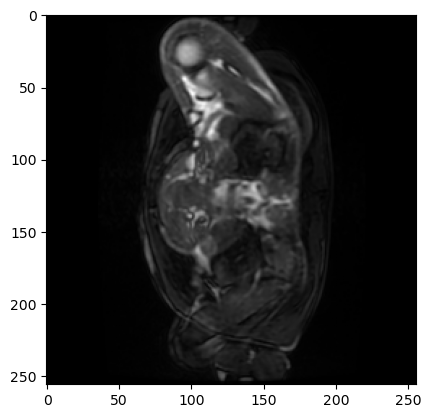

In [83]:
print(data.shape)

import matplotlib.pyplot as plt

for i in range(50,118):
    plt.imshow(data[:,:,i,0], cmap='gray')
    plt.show()
    
    

## torch, figures crossed

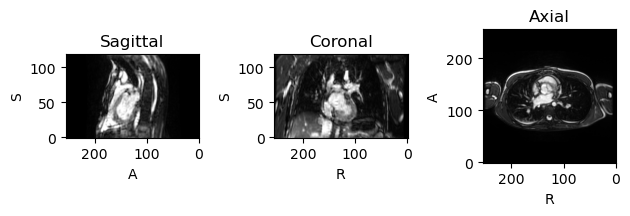

In [91]:
import torchio as tio                    # v0.19 or later
t1 = tio.ScalarImage('/home/ayeluru/vascular-superenhancement-4d-flow/working_dir/all_patients/patient_data/Bukrukesh/nifti/3d_cine_Bukrukesh.nii.gz')

t1.plot()        # wraps torchio.visualization.plot_volume under the hood


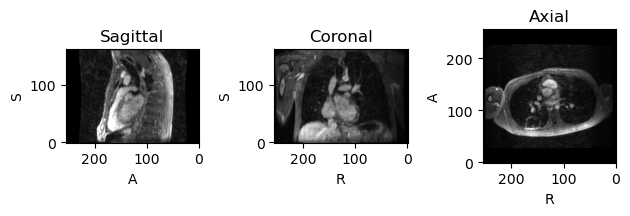

In [92]:
t2 = tio.ScalarImage('/home/ayeluru/vascular-superenhancement-4d-flow/working_dir/all_patients/patient_data/Bukrukesh/nifti/4d_flow_mag_Bukrukesh.nii.gz')
t2.plot()